In [16]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

### Constants

In [17]:
# Mass
m = 0.044

# Principle moments of inertia
J_y = 1.60e-05
J_x = 1.60e-05
J_z = 1.60e-05
J_in1 = sym.diag(J_x, J_y, J_z)


# Acceleration of gravity
g = 9.81

# # Pendulum parameters
# l_pen = 150e-3 # maybe m
# m_pen = 0.006



In [45]:
def Rotate(alpha, beta, gamma):
    Rz = sym.Matrix([[sym.cos(alpha), -sym.sin(alpha), 0],
                 [sym.sin(alpha), sym.cos(alpha), 0],
                 [0, 0, 1]])

    Ry = sym.Matrix([[sym.cos(beta), 0, sym.sin(beta)],
                 [0, 1, 0],
                 [-sym.sin(beta), 0, sym.cos(beta)]])

    Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(gamma), -sym.sin(gamma)],
                 [0, sym.sin(gamma), sym.cos(gamma)]])

    R_VtoO = Rz * Ry * Rx

    return R_VtoO

def N_func(alpha, beta, gamma):
    Ninv = sym.Matrix([[sym.cos(beta)*sym.cos(gamma), -sym.sin(gamma), 0],
                       [sym.cos(beta)*sym.sin(gamma), sym.cos(gamma), 0],
                       [-sym.sin(beta), 0, 1]])

    # N = sym.simplify(Ninv.inv())
    N = Ninv.inv()
    return N

### State Derivative

Calculates the derivative of the state.

In [58]:
def propogate_state(state, inputs):
    # state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]
    # inputs: [tau_x, tau_y, tau_z, f_z]
    Rotation_matrix = Rotate(state[6], state[7], state[8])
    N = N_func(state[6], state[7], state[8])
    second_derivatives = Rotation_matrix * sym.Matrix([0, 0, inputs[3]])/m + sym.Matrix([0, 0, -g])
    angle_derivatives = N * sym.Matrix([state[9], state[10], state[11]]) # [gamma_dot, beta_dot, alpha_dot]
    tau_in1 = sym.Matrix([inputs[0], inputs[1], inputs[2]])
    w_01in1 = sym.Matrix([state[9], state[10], state[11]])
    w_derivatives = J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1))
    state_dot = np.zeros(12)
    state_dot[0] = state[1]
    state_dot[1] = second_derivatives[0]
    state_dot[2] = state[3]
    state_dot[3] = second_derivatives[1]
    state_dot[4] = state[5]
    state_dot[5] = second_derivatives[2]
    state_dot[6] = angle_derivatives[2]
    state_dot[7] = angle_derivatives[1]
    state_dot[8] = angle_derivatives[0]
    state_dot[9] = w_derivatives[0]
    state_dot[10] = w_derivatives[1]
    state_dot[11] = w_derivatives[2]

    return state_dot

In [ ]:
o_x, o_z, o_x_dot, o_z_dot, theta, theta_dot, alpha, alpha_dot, f_z, tau_y = sym.symbols(r'o_x, o_z, o_x_dot, o_z_dot, theta, theta_dot, alpha, alpha_dot, f_z, tau_y')


### RK4 propogator

To get the next state

In [59]:
def rk4(state, inputs, delta_t):
    y1 = propogate_state(state, inputs)
    y2 = propogate_state(state + 1/2*delta_t*y1, inputs)
    y3 = propogate_state(state + 1/2*delta_t*y2, inputs)
    y4 = propogate_state(state + delta_t*y3, inputs)

    return state + 1/6 * delta_t *(y1 + 2*y2 + 2*y3 + y4)


### Controller

To calculate the inputs based on the current state. The K values are from the `planar_problem_state_space.ipynb` notebook.

In [64]:
def controller(state, state_des):
    # K = np.array([[-3.16227766e-04, -5.62372285e-04, -3.75118589e-18,
    #     -3.58037631e-18,  1.18799716e-02,  6.92935127e-04,
    #     -1.52344145e-02, -1.80434720e-03],
    #    [ 2.70362764e-15,  2.30331138e-15,  3.16227766e-01,
    #      3.62798534e-01, -4.13236788e-14, -1.14572042e-15,
    #      6.80987900e-14,  7.57825355e-15]])
    # u = -K @ (state - state_des)
    # u[1] += (m + m_pen)*g
    u = np.zeros(4)
    u[3] = m*g
    return u

Run the sim

In [65]:
def sim(times,inputs_data, state_data, state_des, delta_t):
    for i, time in enumerate(times):

        if i == 0:
            continue

        else:
            inputs_data[i-1] = controller(state_data[i-1], state_des)
            state_data[i] = rk4(state_data[i-1], inputs_data[i-1], delta_t)

In [69]:
# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

# Set up sim
delta_t = 0.01
total_t = 10
times = np.arange(0, total_t + delta_t/2, delta_t)
inputs_data = np.zeros((len(times), 4))
state_data = np.zeros((len(times), 12))

# Desired States
state_des = np.array([0., 0., 0.0, 0., 3., 0., 0., 0., 0., 0., 0., 0.])
# Initial condition
state_data[0] = np.array([0., 0., 0.0, 0., 3., 0., 0., 0.2, 0., 0., 0., 0.])

# Run sim
sim(times, inputs_data, state_data, state_des, delta_t)

### Plotting and animation

Text(0.5, 0, 'time (s)')

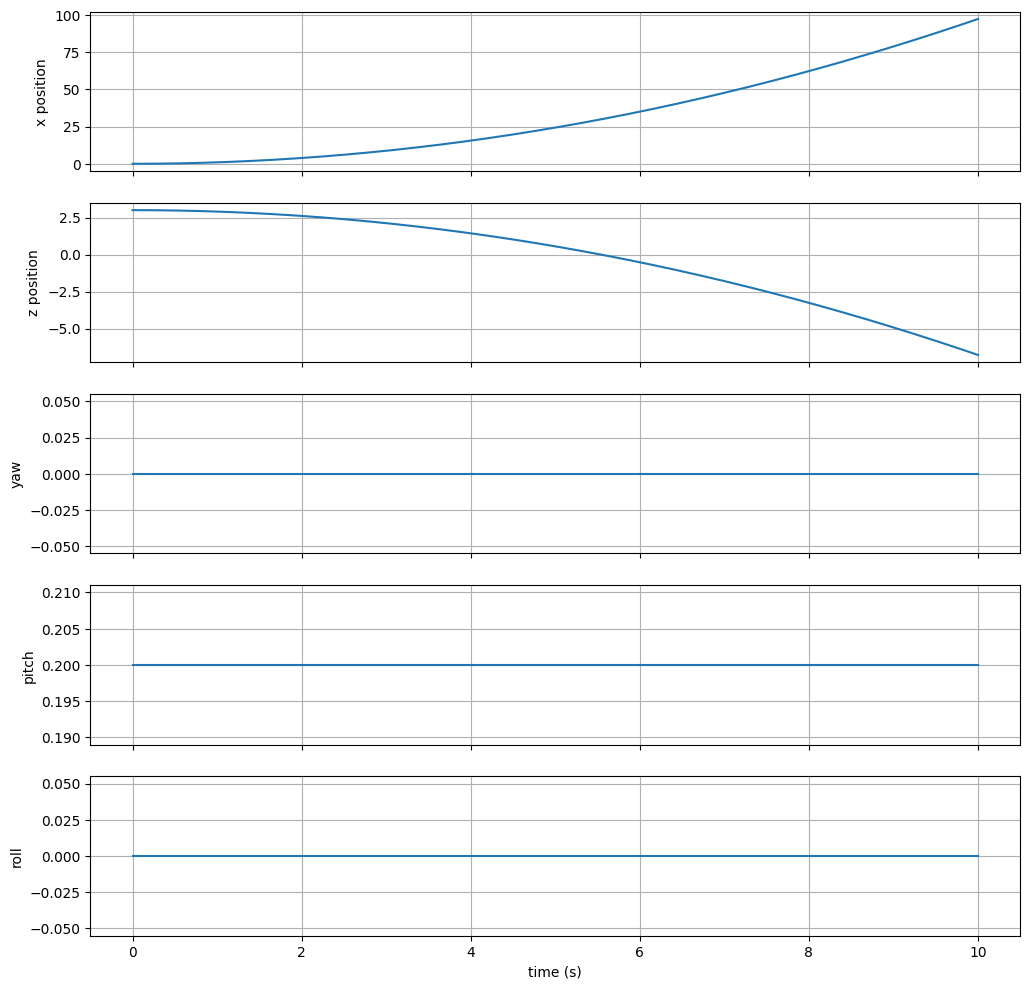

In [72]:
fig, (ax_o_x, ax_o_z, ax_alpha, ax_beta, ax_gamma) = plt.subplots(5, 1, figsize=(12, 12), sharex=True)

# state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]

ax_o_x.plot(times, state_data[:,0])
ax_o_x.set_ylabel('x position')
ax_o_z.plot(times, state_data[:,4])
ax_o_z.set_ylabel('z position')
ax_alpha.plot(times, state_data[:,6])
ax_alpha.set_ylabel('yaw')
ax_beta.plot(times, state_data[:,7])
ax_beta.set_ylabel('pitch')
ax_gamma.plot(times, state_data[:,8])
ax_gamma.set_ylabel('roll')
ax_o_x.grid()
ax_o_z.grid()
ax_alpha.grid()
ax_beta.grid()
ax_gamma.grid()
ax_gamma.set_xlabel('time (s)')


Text(0.5, 23.999999999999993, 'time (s)')

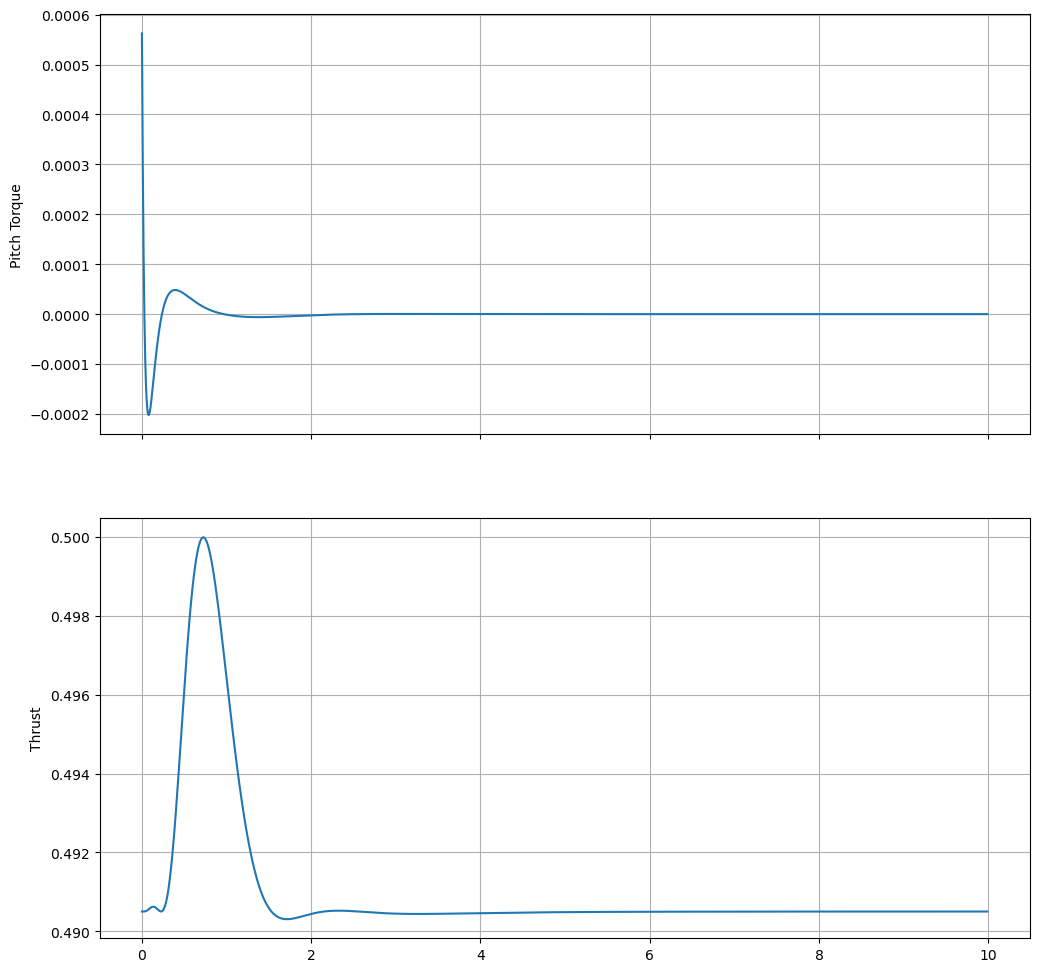

In [199]:
fig, (ax_tau_y, ax_f_z) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

ax_tau_y.plot(times[:-1], inputs_data[:-1,0])
ax_f_z.plot(times[:-1], inputs_data[:-1,1])
ax_tau_y.set_ylabel('Pitch Torque')
ax_f_z.set_ylabel('Thrust')
ax_tau_y.grid()
ax_f_z.grid()
ax_alpha.set_xlabel('time (s)')

In [200]:
# Write State Data and Timestamps to a csv for Animation

import os

record = []
for point in range(len(times)):
    cur_point = []
    cur_point.append(str(times[point]))
    cur_point.append(str(state_data[point, 0])) #x-pos
    cur_point.append(str(state_data[point, 2])) #z-pos
    cur_point.append(str(state_data[point, 4])) #theta
    cur_point.append(str(state_data[point,6]))  #alpha
    record.append(cur_point)
print(state_data[13, 6])
output_file = 'sim.csv'
with open(output_file, 'w') as f:
    f.write("time,x,z,theta,alpha\n")
    for point in record:
        f.write(f"{','.join(point)}\n")

-0.01185280622935667


### Controller Design


In [85]:
# o_x, o_y, o_z, alpha, beta, gamma, wx, wy, wz, ox_dot, oy_dot, oz_dot= sym.symbols(r'o_x o_y o_z \alpha \beta \gamma w_x w_y w_z ox_{dot} oy_{dot} oz_{dot}')
# tau_x, tau_y, tau_z, f_z = sym.symbols('tau_x, tau_y, tau_z, f_z')
# m, Jx, Jy, Jz = sym.symbols('m J_x J_y J_z')
# # state: [o_x, o_x_dot, o_y, o_y_dot, o_z, o_z_dot, alpha, beta, gamma, wx, wy, wz]
# # inputs: [tau_x, tau_y, tau_z, f_z]
# Rotation_matrix = Rotate(alpha, beta, gamma)
# N = N_func(alpha, beta, gamma)
# second_derivatives = Rotation_matrix * sym.Matrix([0, 0, f_z])/m + sym.Matrix([0, 0, -g])
# angle_derivatives = N * sym.Matrix([wx, wy, wz]) # [gamma_dot, beta_dot, alpha_dot]
# tau_in1 = sym.Matrix([tau_x, tau_y, tau_z])
# w_01in1 = sym.Matrix([wx, wy, wz])
# w_derivatives = J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1))
# f = sym.zeros(12,1)
# f[0] = ox_dot
# f[1] = second_derivatives[0]
# f[2] = oy_dot
# f[3] = second_derivatives[1]
# f[4] = oz_dot
# f[5] = second_derivatives[2]
# f[6] = angle_derivatives[2]
# f[7] = angle_derivatives[1]
# f[8] = angle_derivatives[0]
# f[9] = w_derivatives[0]
# f[10] = w_derivatives[1]
# f[11] = w_derivatives[2]

In [86]:
# f

Matrix([
[                                                                                                                                                                     ox_{dot}],
[                                                                                          22.7272727272727*f_z*(sin(\alpha)*sin(\gamma) + sin(\beta)*cos(\alpha)*cos(\gamma))],
[                                                                                                                                                                     oy_{dot}],
[                                                                                          22.7272727272727*f_z*(sin(\alpha)*sin(\beta)*cos(\gamma) - sin(\gamma)*cos(\alpha))],
[                                                                                                                                                                     oz_{dot}],
[                                                                                                         